In [27]:
# GNN 
import torch
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

# Data handling 
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from connectome_loaders import load_flywire

# Plotting
import matplotlib.pyplot as plt

### What are graph neural networks?

A **Graph Neural Network (GNN)** is a type of deep learning model designed to operate on graph-structured data. Unlike traditional neural networks that process data in fixed-size vectors or arrays, GNNs are specifically adapted to process data that can be naturally described by graphs, such as social networks, molecular structures, and citation networks. There are three main groups of tasks that can be implemented with a GNN:

1) **Node-level task**: Predicting the properties of nodes in the graph. Examples include classifying the type of each node in the graph.
2) **Graph-level task**: Predicting the global properties of a whole graph. An example is predicting some property of molecular graph structures (i.e. odorant binding).
3) **Edge-level task**: Predicting the properties of edges in the graph. Examples include predicting the existence, strength, or nature of relationships between nodes in the graph. 

In this notebook, you will implement an edge-level task, **link prediction**, on a portion of the FlyWire connectome graph. 

### Input data
The input to a GNN is a graph structure composed of node attributes, edge attributes, and global graph attributes. 

Our first goal is to wrangle the FlyWire dataset into a graph format suitable for a GNN. We will use the data loaders in the [connectome_tools package](https://github.com/alitwinkumar/connectome_tools) to load in the list of FlyWire neurons.

In [28]:
# Use connectome_loaders to import FlyWire neurons 
neurons, _ = load_flywire('FlyWire_data/') # datapath to FlyWire 
neurons

,root_id,group,nt_type,nt_type_score,da_avg,ser_avg,gaba_avg,glut_avg,ach_avg,oct_avg,...,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve,J_idx,J_idx_post,J_idx_pre
0,720575940596125868,LO.LOP,ACH,0.57,0.03,0.00,0.05,0.28,0.57,0.07,...,NaN,NaN,T5c,NaN,NaN,right,NaN,0,0,0
1,720575940597856265,ME,ACH,0.85,0.01,0.00,0.03,0.04,0.85,0.07,...,NaN,NaN,Tm16,NaN,NaN,right,NaN,1,1,1
2,720575940597944841,ME.LO,ACH,0.82,0.02,0.00,0.01,0.05,0.82,0.09,...,NaN,NaN,CB3851,NaN,NaN,right,NaN,2,2,2
3,720575940598267657,ME,GABA,0.74,0.01,0.01,0.74,0.19,0.03,0.02,...,NaN,NaN,TmY15,NaN,NaN,right,NaN,3,3,3
4,720575940599333574,ME,ACH,0.61,0.02,0.00,0.13,0.13,0.61,0.11,...,NaN,NaN,Tm1,NaN,NaN,right,NaN,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139250,720575940661335681,GNG,GABA,0.71,0.00,0.00,0.71,0.17,0.11,0.00,...,NaN,NaN,CB0180,NaN,MX12__prim,left,NaN,139250,139250,139250
139251,720575940661336193,ME.LO,ACH,0.62,0.02,0.00,0.18,0.16,0.62,0.03,...,NaN,NaN,TmY3,NaN,NaN,left,NaN,139251,139251,139251
139252,720575940661337217,SCL.MB_ML,ACH,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,Kenyon_Cell,NaN,NaN,KCab-p,MBp4,left,NaN,139252,139252,139252
139253,720575940661338497,GNG,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,CB0904,NaN,putative_primary,right,PhN,139253,139253,139253


Then, we will import the FlyWire connectivity data in the format of an edgelist. In this table, each row represents a connection between a pair of FlyWire neurons, or an edge between this pair in our input graph. The strength of the connection is taken to be the number of synapses between this pair of neurons, which is given in the "syn_count" column. 

In [29]:
# Import FlyWire connections as an edgelist
connections = pd.read_csv('FlyWire_data/connections.csv')
connections

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


Although we can deploy our GNN on the full FlyWire graph, this takes a long time to train. To speed things up, we are going to start with a subset of the FlyWire dataset. 

One option is to only look at neurons and their connections within a specific neuropil (brain region) of interest in the fly brain. In this tutorial, we are looking at neurons in the left lateral horn of the fly, a region implicated in innate odor behavior.  

In [30]:
# Restrict dataset to a specific neuropil 
neuropil_of_interest = 'LH_L'
connections = connections[connections['neuropil'] == neuropil_of_interest] # Filter connections in edgelist by neuropil of interest

lh_neurons = list(np.unique(list(connections['pre_root_id']) + list(connections['post_root_id']))) # Subselect neurons in neuropil of interest
neurons = neurons[neurons['root_id'].isin(lh_neurons)]

print('Number of neurons in ' + neuropil_of_interest + ': ' + str(len(neurons)))

Number of neurons in LH_L: 4067


The nodes of our graph input will be the neurons, and the edges will be the connections between them. We will also include the following attributes:

 - Node attributes: The cell type of each neuron (this will be represented as a one-hot encoding)
 - Edge attributes: The strength of connectivity (synaptic count) of each connection

This of course doesn't capture all of the rich metadata present in the FlyWire connectome. For example, you can play around with incorporating other metadata such as neurotransmitter identity or spatial information. 

In [31]:
all_neurons = list(neurons['root_id']) # List of neurons in graph
all_neuron_types = list(neurons['cell_type']) # List of types for each neuron in graph

# %%
all_unique_types = np.array((neurons['cell_type'].unique())) # List of unique neuron types in graph

In [32]:
# Node attributes: The cell type of each neuron (this will be represented as a one-hot encoding)
# (num_nodes, num_feats)
node_types = np.zeros((len(all_neurons), len(all_unique_types)))
for i_neuron, neuron in enumerate(all_neurons):
    i_type = np.where(all_unique_types == all_neuron_types[i_neuron])
    assert len(i_type) == 1
    node_types[i_neuron, i_type] = 1

In [33]:
# Edge attributes: The strength of connectivity (synaptic count) of each connection
connections = connections.astype({"syn_count": 'float32'})

We are then going to create a graph object using a package called [networkx](https://networkx.org/documentation/stable/index.html). Networkx has tools for representing and working with graph information as well as hundreds of implementations of popular graph algorithms (https://networkx.org/documentation/stable/reference/algorithms/index.html). We're doing this because the package we'll use to configure our GNN input can read a networkx graph easily in one line of code. 

In [34]:
# networkx graph -> PyTorch geometric object transformation is easy
G = nx.DiGraph() # Initialize a networkx directed graph 
G = nx.from_pandas_edgelist(connections, 'pre_root_id', 'post_root_id', ['syn_count'], create_using=nx.DiGraph()) # Create a graph with our node and edge information

### PyTorch Geometric (PyG)

PyTorch Geometric (PyG) is a popular library for efficiently working with graph-structured data in deep learning, built on top of PyTorch. We will be using PyG to define our graph input as well as design, train, and evaluate our GNN model. 

We'll go over the basic functions and data structures in this notebook, but we highly suggest checking out the PyG documentation (https://pytorch-geometric.readthedocs.io/en/latest/) for an idea of how you can use PyG to build up GNNs. There are also some great tutorial notebooks specifically designed for learning PyG concepts here: https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html. 

The core data structure in PyG is the **'Data' (torch_geometric.data.Data) object**. It stores a single graph's information, including node-level attributes, edge-level attributes, and global graph-level attributes. We've already extracted the attributes we want to include above, so we are ready to construct our data object, called "graph".

For more on what a 'Data' object holds, see https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#data-handling-of-graphs or check out the help query below.

In [35]:
# More information on the PyG Data object
torch_geometric.data.Data?

Init signature:
torch_geometric.data.Data(
    x: Optional[torch.Tensor] = None,
    edge_index: Optional[torch.Tensor] = None,
    edge_attr: Optional[torch.Tensor] = None,
    y: Optional[torch.Tensor] = None,
    pos: Optional[torch.Tensor] = None,
    **kwargs,
)
Docstring:     
A data object describing a homogeneous graph.
The data object can hold node-level, link-level and graph-level attributes.
In general, :class:`~torch_geometric.data.Data` tries to mimic the
behavior of a regular Python dictionary.
In addition, it provides useful functionality for analyzing graph
structures, and provides basic PyTorch tensor functionalities.
See `here <https://pytorch-geometric.readthedocs.io/en/latest/get_started/
introduction.html#data-handling-of-graphs>`__ for the accompanying
tutorial.

.. code-block:: python

    from torch_geometric.data import Data

    data = Data(x=x, edge_index=edge_index, ...)

    # Add additional arguments to `data`:
    data.train_idx = torch.tensor([...], dtyp

In [36]:
# Convert graph into PyTorch geometric object
graph = from_networkx(G, group_edge_attrs=['syn_count']) # Add edge attributes from networkx graph

graph.x = torch.from_numpy(node_types).float() # Add node attributes (one-hot encoded cell type)


In [37]:
# Node attributes
graph.x # One-hot encoded cell types

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
# Edge attributes: connectivity 
graph.edge_index.T # Edge indices (connectivity information)

tensor([[   0,    1],
        [   0,  698],
        [   0, 1420],
        ...,
        [4040, 3293],
        [4061, 1952],
        [4066,  487]])

In [39]:
# Edge attributes: synaptic weights of each edge (strength of connectivity)
graph.edge_attr

tensor([[10.],
        [ 6.],
        [ 8.],
        ...,
        [ 2.],
        [ 1.],
        [ 1.]])

### Link prediction model
We are finally ready to start building our graph neural network. Our graph neural network will consist of **Graph Convolution layers** [(torch_geometric.conv.GCNConv)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html). In a graph convolution layer, each node aggregates information from its neighboring nodes to update its feature representation. This process leverages the graph's connectivity structure, encoded in our graph Data object, to perform weighted sums of the neighbor node features.  By stacking multiple graph convolution layers (in our case, two), a GNN can capture and propagate information over larger portions of the connectome.  

<img src="https://iili.io/Jb56mle.jpg" alt="Figure1_ConvLayers" style="width:900px;"/>

In [40]:
# Code adapted from https://gist.github.com/tomonori-masui/144c2057a64ec892a0a88066607eb3d2#file-link_predictor-py 
# Define GNN architecture
class Net(torch.nn.Module):
    # Initialize the GNN
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels) # Graph convolution layer 1
        self.conv2 = GCNConv(hidden_channels, out_channels) # Graph convolution layer 2

    # Forward pass through the network
    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu() # Apply Conv1 + ReLU nonlinearity
        return self.conv2(x, edge_index) # Apply Conv2

    # Similarity score between pairs of nodes at a potential edge; the higher this is, the more likely an edge exists
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum( # Product of a pair of nodes on each edge
            dim=-1 # Sum results across all dims
        ) 

    # Recover full adjacency matric from node embeddings
    def decode_all(self, z):
        prob_adj = z @ z.t() # Compute dot product across all node pairs
        return (prob_adj > 0).nonzero(as_tuple=False).t() # Indices of edges with postiive probability


Now that we have created the model architecture and configured the input data, we are ready to implement link prediction. Here are the basic **steps of our link prediction algorithm**:

  1. Generate node embeddings by passing the data through the encoding model (the two graph convolutional layers and one nonlinearity as described above)
  2. Randomly add negative links to the original graph to turn the task into a binary classification task (classifying an edge as either positive or negative)
  3. Generate link predictions (i.e. binary classifications) on all the edges including the negative links from the node embeddings using the decoder. The decoder generates a similarity score by computing the dot product of node embeddings at each edge, and uses this similarity score to generate probabilities of edge existence (see 'decode' and 'decode_all' functions above). 

Schematic below from Tomonuri Masui. 

[![Jb0dzoQ.md.png](https://iili.io/Jb0dzoQ.md.png)](https://freeimage.host/i/Jb0dzoQ)

In [41]:
# Training 
def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=300
):

    train_losses = [] 
    val_losses = []
    for epoch in range(1, n_epochs + 1):

        model.train() 
        optimizer.zero_grad() # Clear gradients for all learnable params

        # Step 1: Generate node embeddings
        z = model.encode(train_data.x, train_data.edge_index) # train_data.x: node features, train_data.edge_index: connectivity

        # Step 2: Randomly generate negative links for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        # Combine existing positive and new negative edges
        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Step 3: Use decoder to generate link existence probabilities on each edge
        out = model.decode(z, edge_label_index).view(-1)

        # Compute loss between predicted and actual edges
        loss = criterion(out, edge_label)

        # Backpropagation to compute gradients
        loss.backward()

        # Update model params
        optimizer.step()

        # Evaluate training and validation losses
        val_auc, _, _ = eval_link_predictor(model, val_data)

        train_losses.append(loss.detach().numpy())
        val_losses.append(val_auc)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}")

    return model, train_losses, val_losses

In [42]:
# Testing
@torch.no_grad() 
def eval_link_predictor(model, data):

    model.eval()

    # Compute node embeddings on input graph data (forward pass)
    z = model.encode(data.x, data.edge_index)

    # Use decoder to generate link predictions
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    # Return score between predicted and ground truth links, ground truth links, predicted links
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy()), data.edge_label.cpu().numpy(), out.cpu().numpy()

In [43]:
# Randomly split edges into training and validation data
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(graph)

In [44]:
print('train data: ' + str(train_data))
print('val data:' + str(val_data))
print('test data:' + str(test_data))

train data: Data(edge_index=[2, 40214], edge_attr=[40214, 1], num_nodes=4067, x=[4067, 1265], edge_label=[20107], edge_label_index=[2, 20107])
val data:Data(edge_index=[2, 40214], edge_attr=[40214, 1], num_nodes=4067, x=[4067, 1265], edge_label=[2364], edge_label_index=[2, 2364])
test data:Data(edge_index=[2, 42578], edge_attr=[42578, 1], num_nodes=4067, x=[4067, 1265], edge_label=[4730], edge_label_index=[2, 4730])


We will now train our model over many epochs and evaluate model performance on our validation dataset.

In [45]:
# Initialize model with input size, hidden layer size, output size
model = Net(len(all_unique_types), 128, 64).to('cpu')

# Initialize optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# Initialize loss criterion (binary cross-entropy)
criterion = torch.nn.BCEWithLogitsLoss()

# Train link prediction model
model, train_losses, val_losses = train_link_predictor(model, train_data, val_data, optimizer, criterion)

# Evaluate trained model performance 
test_auc, _, _ = eval_link_predictor(model, test_data)

# Final trained model performance on validation dataset
print(f"Final validation accuracy: {test_auc:.3f}")

Epoch: 010
Epoch: 020
Epoch: 030
Epoch: 040
Epoch: 050
Epoch: 060
Epoch: 070
Epoch: 080
Epoch: 090
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190
Epoch: 200
Epoch: 210
Epoch: 220
Epoch: 230
Epoch: 240
Epoch: 250
Epoch: 260
Epoch: 270
Epoch: 280
Epoch: 290
Epoch: 300
Final validation accuracy: 0.930


We see that the loss during training decreases over the course of several training epochs and the accuracy on the validation set increases over several epochs. 

Text(0, 0.5, 'AUC')

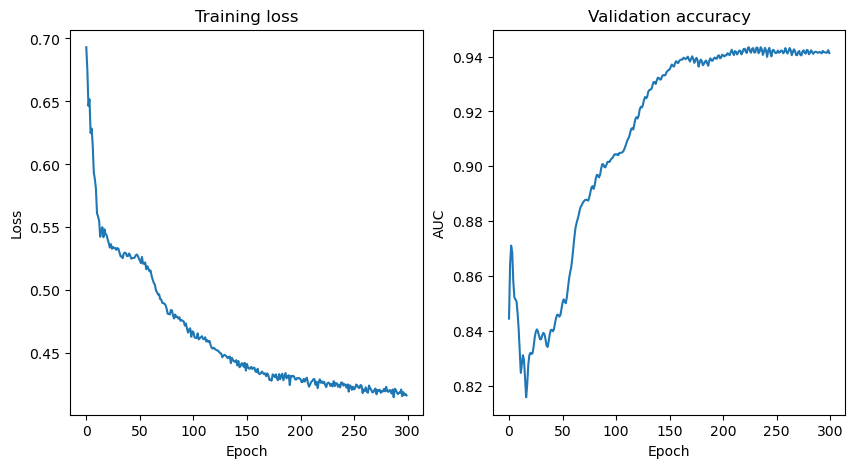

In [46]:
# Plot losses
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train loss')
ax[1].plot(val_losses, label='validation accuracy (auc)')
ax[0].set_title('Training loss')
ax[1].set_title('Validation accuracy')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('AUC')

In [47]:
# Retrieve ground truth links and predicted links from trained model on test dataset
_, actual_links, predicted_links,  = eval_link_predictor(model, test_data)

We can also plot histograms of the predicted link probabilities after training our model both for edges with positive links in the ground truth data and negative links in the ground truth data (no connection). We see that where the ground truth indicates the existence of an edge, link prediction probabilities are generally high. 

Text(0.5, 0, 'Predicted link probabilities')

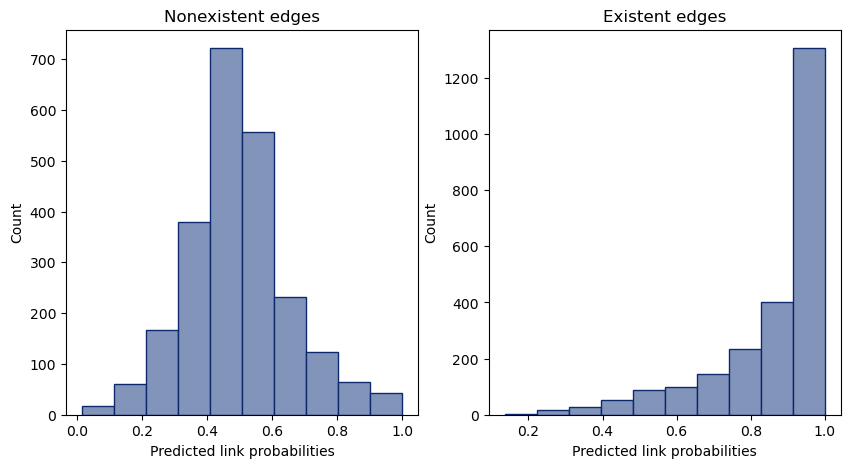

In [48]:
split = int(len(actual_links)/2)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(np.sort(predicted_links[split:]), edgecolor='#0C296E', facecolor='#8394BB')
ax[1].hist(np.sort(predicted_links[:split]), edgecolor='#0C296E', facecolor='#8394BB')

ax[0].set_title('Nonexistent edges')
ax[1].set_title('Existent edges')

ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')

ax[0].set_xlabel('Predicted link probabilities')
ax[1].set_xlabel('Predicted link probabilities')

### Objective
One objective could be to determine what factors improve link prediction on the test dataset (i.e. maximize test_auc above). Here are some related ideas:

1. Try link prediction on **different neuropils of interest and/or the full FlyWire brain**. Is there a lot of variation in link prediction accuracy amongst different brain regions? 
2. What are the **failure modes of the link prediction model**? Take a look at which edges are predicted poorly by the model - is there something notable about these edges?
3. Adding **different types of metadata**. Currently we are using a limited set of metadata: cell type information and edge strength (synaptic count). You can try incorporating a number of other features such as neurotransmitter type (or simply excitatory vs. inhibitory connections). You could add metadata to nodes and/or edges. See the Hello_FlyWire notebook for an idea of what types of data are present in the FlyWire connectome. 
4. Does **layering more graph convolutional layers** increase or decrease performance? Is there a sweet spot and what does this say about the FlyWire connectome's connectivity features? 
5. Adapt the GNN to perform a **different task** on the FlyWire connectome such as node cell type prediction or neurotransmitter prediction. 

### References

https://distill.pub/2021/gnn-intro/ (Great introduction to the concepts behind GNNs)  
https://arxiv.org/abs/1609.02907 (Paper with implementation details of graph convolutional layers)  
https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275 (Very similar tutorial for link prediction on citation graphs)  
https://distill.pub/2021/understanding-gnns/ (More on graph convolutional operators)  